# Tutorial: EqualizedOddsImprovement Metric

This notebook demonstrates how to use the `EqualizedOddsImprovement` metric to evaluate fairness in synthetic data generation. We'll use the Adult dataset to show how synthetic data can potentially improve fairness in machine learning models.

## What is Equalized Odds?

Equalized odds is a fairness criterion that requires the True Positive Rate (TPR) and False Positive Rate (FPR) to be equal across different groups defined by a sensitive attribute (like gender, race, etc.). 

The `EqualizedOddsImprovement` metric compares how well a model trained on synthetic data maintains fairness compared to a model trained on real data, both evaluated on the same validation set.


## Setup and Imports

First, let's install and import all the necessary libraries:


In [ ]:
!pip install sdv
!pip install xgboost
!pip install matplotlib

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import json

from sdv.single_table import TVAESynthesizer
from sdv.datasets.demo import download_demo
from sdv.sampling import Condition

from sdmetrics.single_table.equalized_odds import EqualizedOddsImprovement

print("All libraries imported successfully!")

All libraries imported successfully!


## Step 1: Load and Explore the Adult Dataset

We'll use the Adult dataset from the SDV demo datasets. This dataset contains information about individuals and whether they earn more than $50K per year.


In [16]:
# Load the adult dataset
real_data, metadata = download_demo('single_table', 'adult')

print(f"Dataset shape: {real_data.shape}")
print(f"\nFirst few rows:")
real_data.head()

Dataset shape: (32561, 15)

First few rows:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,27,Private,177119,Some-college,10,Divorced,Adm-clerical,Unmarried,White,Female,0,0,44,United-States,<=50K
1,27,Private,216481,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,<=50K
2,25,Private,256263,Assoc-acdm,12,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,<=50K
3,46,Private,147640,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,Amer-Indian-Eskimo,Male,0,1902,40,United-States,<=50K
4,45,Private,172822,11th,7,Divorced,Transport-moving,Not-in-family,White,Male,0,2824,76,United-States,>50K


In [17]:
# Create a copy of the original data for our modifications
modified_data = real_data.copy()

# For sex=Male: If salary is <50K, flip it to >=50K with 25% probability
# If salary is >=50K, keep as-is
# Keep sex=Female as-is

np.random.seed(42)  # For reproducibility

# Find Male rows with <50K salary
mask_male_low_salary = (modified_data['sex'] == 'Male') & (modified_data['label'] == '<=50K')
male_low_salary_indices = modified_data[mask_male_low_salary].index

# Generate random probabilities for each Male with <50K salary
random_probs = np.random.random(len(male_low_salary_indices))

# Flip to >=50K with 25% probability
flip_mask = random_probs < 0.25
indices_to_flip = male_low_salary_indices[flip_mask]

print(f"Total Males with <=50K salary: {len(male_low_salary_indices)}")
print(f"Males being flipped to >50K (25% probability): {len(indices_to_flip)}")

# Apply the flips
modified_data.loc[indices_to_flip, 'label'] = '>50K'

print(f"\nModified income distribution by sex:")
modified_crosstab = pd.crosstab(modified_data['sex'], modified_data['label'], normalize='index') * 100
print(modified_crosstab)

# Use the modified data for the rest of the analysis
real_data = modified_data

Total Males with <=50K salary: 15128
Males being flipped to >50K (25% probability): 3850

Modified income distribution by sex:
label       <=50K       >50K
sex                         
Female  89.053941  10.946059
Male    51.757687  48.242313


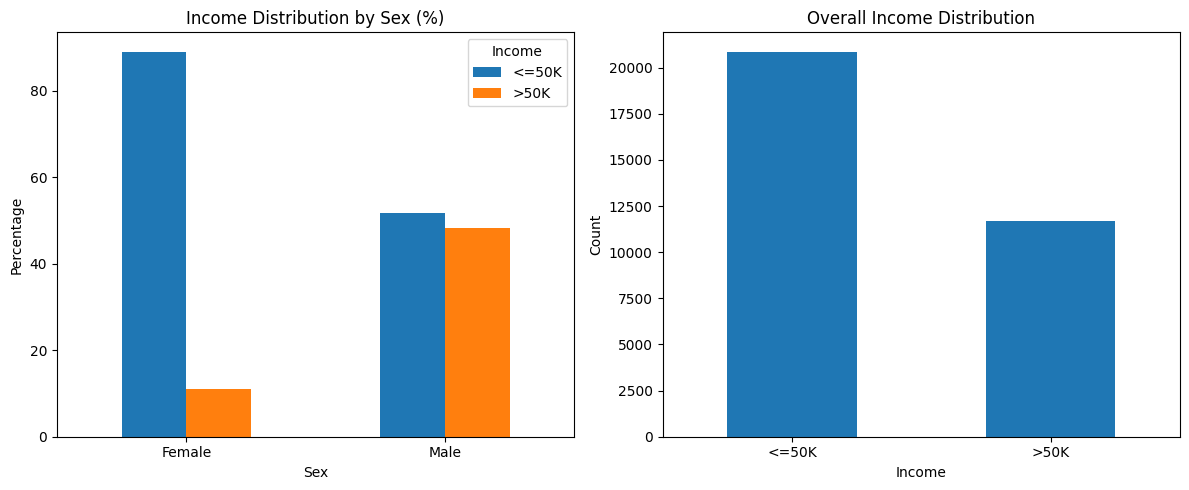

In [18]:
# Visualize the distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# income distribution by sex
crosstab_pct = pd.crosstab(real_data['sex'], real_data['label'], normalize='index') * 100
crosstab_pct.plot(kind='bar', ax=axes[0], rot=0)
axes[0].set_title('Income Distribution by Sex (%)')
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('Percentage')
axes[0].legend(title='Income')

# Overall income distribution
real_data['label'].value_counts().plot(kind='bar', ax=axes[1], rot=0)
axes[1].set_title('Overall Income Distribution')
axes[1].set_xlabel('Income')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

## Step 2: Split Data into Training and Validation Sets

In [19]:
training_data, validation_data = train_test_split(
    real_data,
    test_size=0.3,
    random_state=42,
)

print(f"\nTraining set shape: {training_data.shape}")
print(f"Validation set shape: {validation_data.shape}")

# Verify all combinations exist in both sets
print("\nTraining set combinations:")
print(pd.crosstab(training_data['label'], training_data['sex']))
print("\nValidation set combinations:")
print(pd.crosstab(validation_data['label'], validation_data['sex']))


Training set shape: (22792, 15)
Validation set shape: (9769, 15)

Training set combinations:
sex    Female  Male
label              
<=50K    6719  7903
>50K      799  7371

Validation set combinations:
sex    Female  Male
label              
<=50K    2873  3375
>50K      380  3141


## Step 3: Generate Synthetic Data

We'll use the TVAE (Tabular Variational AutoEncoder) synthesizer to generate synthetic data.


In [20]:
print("Training TVAE synthesizer...")

synthesizer = TVAESynthesizer(metadata=metadata)
synthesizer.fit(training_data)

print("Synthesizer training completed!")

Training TVAE synthesizer...
Synthesizer training completed!


In [21]:
synthetic_data = synthesizer.sample(len(training_data))

print(f"Synthetic data shape: {synthetic_data.shape}")
print("\nTarget and sensitive attribute distribution:")
print(pd.crosstab(synthetic_data['label'], synthetic_data['sex']))

Synthetic data shape: (22792, 15)

Target and sensitive attribute distribution:
sex    Female  Male
label              
<=50K    7168  7767
>50K      638  7219


## Step 4: Evaluate Synthetic Data

Let's evaluate the synthetic data generated with the EqualizedOddsImprovement metric.

In [22]:
result_standard = EqualizedOddsImprovement.compute_breakdown(
    real_training_data=training_data,
    synthetic_data=synthetic_data,
    real_validation_data=validation_data,
    metadata=metadata.to_dict()['tables']['adult'],
    prediction_column_name='label',
    positive_class_label='>50K',
    sensitive_column_name='sex',
    sensitive_column_value='Female'
)

print(f"Score: {result_standard['score']:.4f}")
print(f"\nScore Interpretation:")
print(f"- Score > 0.5 means synthetic data improves fairness")
print(f"- Score < 0.5 means synthetic data worsens fairness")
print(f"- Score = 0.5 means no change in fairness")

Score: 0.3013

Score Interpretation:
- Score > 0.5 means synthetic data improves fairness
- Score < 0.5 means synthetic data worsens fairness
- Score = 0.5 means no change in fairness


In [23]:
print('Full breakdown of the Equalized Odds Improvement metric:')
print(json.dumps(result_standard, indent=2))

Full breakdown of the Equalized Odds Improvement metric:
{
  "score": 0.30130981939126733,
  "real_training_data": {
    "equalized_odds": 0.8050768457284294,
    "prediction_counts_validation": {
      "Female=True": {
        "true_positive": 206,
        "false_positive": 58,
        "true_negative": 2815,
        "false_negative": 174
      },
      "Female=False": {
        "true_positive": 1710,
        "false_positive": 726,
        "true_negative": 2649,
        "false_negative": 1431
      }
    }
  },
  "synthetic_data": {
    "equalized_odds": 0.4076964845109641,
    "prediction_counts_validation": {
      "Female=True": {
        "true_positive": 147,
        "false_positive": 183,
        "true_negative": 2690,
        "false_negative": 233
      },
      "Female=False": {
        "true_positive": 2453,
        "false_positive": 2214,
        "true_negative": 1161,
        "false_negative": 688
      }
    }
  }
}


## Step 5: Generate Conditionally Sampled Synthetic Data

Now let's try to improve fairness by using conditional sampling to create a more balanced dataset where each combination of target and sensitive attributes has equal representation (25% each).

In [24]:
print("Generating conditionally sampled synthetic data...")
print("Each condition will have 25% of the data (equal representation)")

total_samples = len(training_data)
samples_per_condition = total_samples // 4
conditions = [
    Condition({'label': '>50K', 'sex': 'Female'}, num_rows=samples_per_condition),
    Condition({'label': '<=50K', 'sex': 'Female'}, num_rows=samples_per_condition),
    Condition({'label': '>50K', 'sex': 'Male'}, num_rows=samples_per_condition),
    Condition({'label': '<=50K', 'sex': 'Male'}, num_rows=samples_per_condition)
]
balanced_synthetic_data = synthesizer.sample_from_conditions(conditions=conditions)
print(f"Generated {len(balanced_synthetic_data)} samples")

print("\nTarget and sensitive attribute distribution:")
balanced_crosstab = pd.crosstab(balanced_synthetic_data['label'], balanced_synthetic_data['sex'])
print(balanced_crosstab)

Generating conditionally sampled synthetic data...
Each condition will have 25% of the data (equal representation)


Sampling conditions: 100%|██████████| 22792/22792 [00:02<00:00, 9112.02it/s] 

Generated 22792 samples

Target and sensitive attribute distribution:
sex    Female  Male
label              
<=50K    5698  5698
>50K     5698  5698


## Step 6: Evaluate Balanced Synthetic Data

Now let's evaluate the balanced synthetic data to compare it with the standard synthetic data.

In [25]:
result_balanced = EqualizedOddsImprovement.compute_breakdown(
    real_training_data=training_data,
    synthetic_data=balanced_synthetic_data,
    real_validation_data=validation_data,
    metadata=metadata.to_dict()['tables']['adult'],
    prediction_column_name='label',
    positive_class_label='>50K',
    sensitive_column_name='sex',
    sensitive_column_value='Female'
)

print(f"Score: {result_balanced['score']:.4f}")

Score: 0.3518


In [26]:
print('The full breakdown of the Equalized Odds Improvement metric is:')
print(json.dumps(result_balanced, indent=2))

The full breakdown of the Equalized Odds Improvement metric is:
{
  "score": 0.3517672841654742,
  "real_training_data": {
    "equalized_odds": 0.8050768457284294,
    "prediction_counts_validation": {
      "Female=True": {
        "true_positive": 206,
        "false_positive": 58,
        "true_negative": 2815,
        "false_negative": 174
      },
      "Female=False": {
        "true_positive": 1710,
        "false_positive": 726,
        "true_negative": 2649,
        "false_negative": 1431
      }
    }
  },
  "synthetic_data": {
    "equalized_odds": 0.5086114140593778,
    "prediction_counts_validation": {
      "Female=True": {
        "true_positive": 345,
        "false_positive": 1062,
        "true_negative": 1811,
        "false_negative": 35
      },
      "Female=False": {
        "true_positive": 2921,
        "false_positive": 2906,
        "true_negative": 469,
        "false_negative": 220
      }
    }
  }
}


## Step 7: Compare Results and Analysis

Let's compare the results from both approaches to analyze the impact of balanced sampling on fairness.

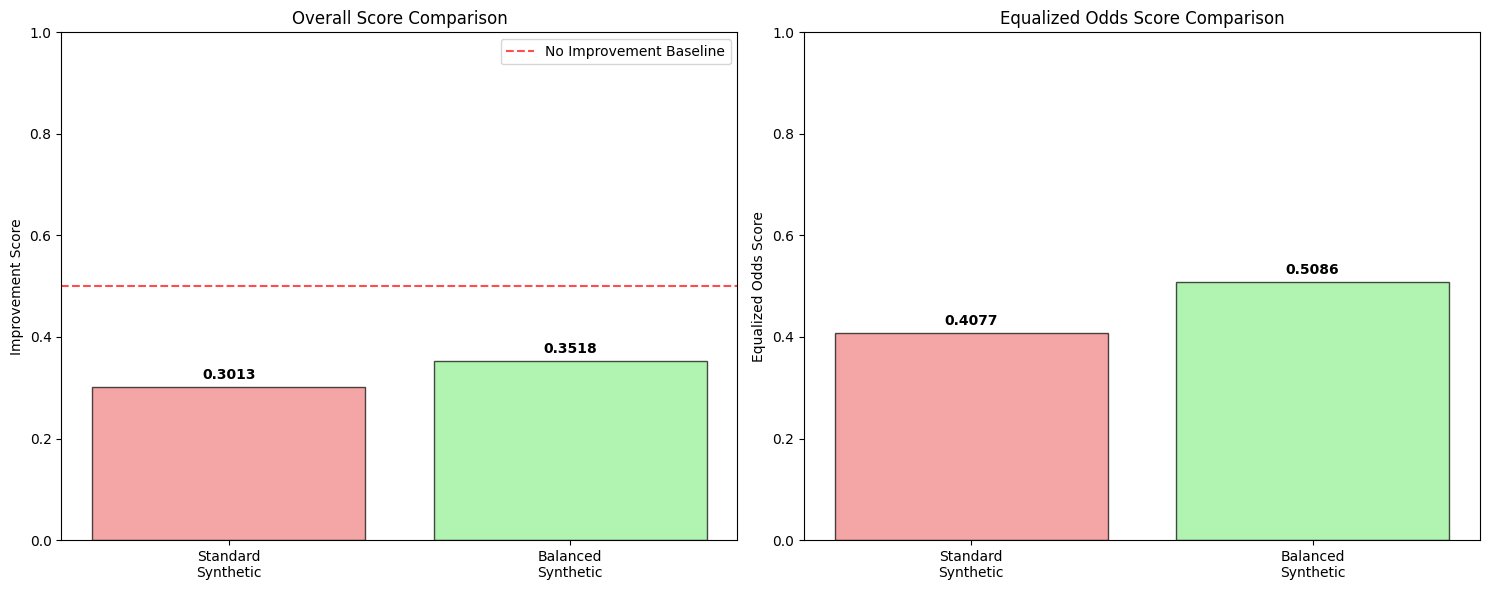

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Improvement scores comparison
scores = [result_standard['score'], result_balanced['score']]
labels = ['Standard\nSynthetic', 'Balanced\nSynthetic']
colors = ['lightcoral', 'lightgreen']

bars1 = axes[0].bar(labels, scores, color=colors, alpha=0.7, edgecolor='black')
axes[0].axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='No Improvement Baseline')
axes[0].set_ylim(0, 1)
axes[0].set_ylabel('Improvement Score')
axes[0].set_title('Overall Score Comparison')
axes[0].legend()

# Add score labels on bars
for bar, score in zip(bars1, scores):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

# Equalized odds scores comparison
eq_scores = [result_standard['synthetic_data']['equalized_odds'], result_balanced['synthetic_data']['equalized_odds']]
bars2 = axes[1].bar(labels, eq_scores, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylim(0, 1)
axes[1].set_ylabel('Equalized Odds Score')
axes[1].set_title('Equalized Odds Score Comparison')

# Add score labels on bars
for bar, score in zip(bars2, eq_scores):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()
